In [1]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
#import tensorflow as tf
import h5py
import keras
from keras import backend as K
from keras import layers
from keras.layers import Input, Multiply,GlobalAveragePooling2D, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Lambda
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.layers.convolutional import *
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras.utils
from keras import callbacks
from keras import utils as np_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import sys
import gc
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow

Using TensorFlow backend.


In [2]:
### Hyperparameters

batch_size = 32
image_size = 224
epoch =30
train_size = 39209
test_size = 12630
num_classes = 43

In [3]:
#files = os.listdir(os.curdir)
#print (os.listdir("../input/oct2017/OCT2017"))
#K.clear_session()
#gc.collect()
train_path =  '/home/sharif-sourajit/Desktop/traffic_sign_classification/Data/GTSRB/Final_Training/Images'
test_path =  '/home/sharif-sourajit/Desktop/traffic_sign_classification/Data/GTSRB/Final_Testing/Images'

classes=['00000','00001','00002','00003','00004','00005','00006','00007','00008','00009','00010','00011','00012','00013','00014','00015','00016','00017','00018','00019','00020','00021','00022','00023','00024','00025','00026','00027','00028','00029','00030','00031','00032','00033','00034','00035','00036','00037','00038','00039','00040','00041','00042']

train_datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             rescale=1.0/255,
                             horizontal_flip=False,
                             fill_mode='nearest'
                                  )

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_batches = train_datagen.flow_from_directory(train_path, target_size=(image_size,image_size),color_mode='rgb', classes=classes, batch_size=batch_size,class_mode='categorical')

test_batches = test_datagen.flow_from_directory(test_path, target_size=(image_size,image_size),color_mode='rgb', classes=classes, batch_size=batch_size, class_mode='categorical')

X = train_batches

print (X.samples)

Found 39209 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.
39209


In [4]:
def dilated_block(X, num_channel, base):
    
    X_shortcut = X
    
    X = BatchNormalization(axis=-1, name=base + '/Branch1/bn_1')(X)
    X = Activation('relu', name=base + '/Branch1/relu_1')(X)
    X = Conv2D(num_channel, (3,3), strides=(1,1), padding='same', name=base + '/Branch1/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)

    X = BatchNormalization(axis=-1, name=base + '/Branch1/bn_2')(X)
    X= Activation('relu', name=base + '/Branch1/relu_2')(X)
    X = Conv2D(num_channel, (3,3), strides=(1,1), padding='same', name=base + '/Branch1/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    
    ##### Branch2 Start #####
    X_shortcut1 = BatchNormalization(axis=-1, name=base + '/Branch2/bn_1')(X_shortcut)
    X_shortcut1 = Activation('relu', name=base + '/Branch2/relu_1')(X_shortcut1)
    X_shortcut1 = Conv2D(num_channel, (3,3), strides=(1,1), dilation_rate=2, padding='same', name=base + '/Branch2/conv_1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut1)
    X = Add(name=base + '/Add1')([X, X_shortcut1])
    ##### Branch2 End #####
    
    X = BatchNormalization(axis=-1, name=base + '/Branch1/bn_3')(X)
    X= Activation('relu', name=base + '/Branch1/relu_3')(X)
    X = Conv2D(num_channel, (3,3), strides=(1,1), padding='same', name=base + '/Branch1/conv_3', kernel_initializer=glorot_uniform(seed=0))(X)

    ##### Branch3 Start #####
    X_shortcut2 = BatchNormalization(axis=-1, name=base + '/Branch3/bn_1')(X_shortcut)
    X_shortcut2 = Activation('relu', name=base + '/Branch3/relu_1')(X_shortcut2)
    X_shortcut2 = Conv2D(num_channel, (3,3), strides=(1,1), dilation_rate=3, padding='same', name=base + '/Branch3/conv_1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut2)
    X = Add(name=base + '/Add2')([X, X_shortcut2])
    ##### Branch3 End #####    
    
    return X

In [5]:
def CNN_model():
    input_shape=(image_size, image_size, 3)
    X_input= Input(input_shape)
    
    X = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=-1, name='bn_1')(X)
    X = Activation('relu', name='relu_1')(X)
    
    X = dilated_block(X, 64, 'Block1')
    X = dilated_block(X, 64, 'Block2')
    #X = dilated_conv_block(X, 16, 'Block2_pool')
    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same' ,name='pool_1')(X)
    
    X = dilated_block(X, 64, 'Block3')
    X = dilated_block(X, 128, 'Block4')
    #X = dilated_conv_block(X, 64, 'Block5_pool')
    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same' ,name='pool_2')(X)
    
    
    X = dilated_block(X, 256, 'Block7')
    #X = dilated_conv_block(X, 128, 'Block7_pool')
    
    X = MaxPooling2D((3,3), strides=(2,2), padding='same' ,name='pool_3')(X)
    
    X = dilated_block(X, 256, 'Block8')
    #X = Conv2D(43, (3,3), strides=(1,1), padding='same', name='conv_9', kernel_initializer=glorot_uniform(seed=0))(X)
    X = AveragePooling2D((8,8), strides=(1,1), name='avg_pool')(X)
    
    X = Flatten(name='Flatten')(X)
    X = Dense(512, name='Dense_1')(X)
    #X = Dropout(0.2)(X)
    X = Dense(num_classes, name='Dense_2')(X)
    X = Activation('softmax', name='classifier')(X)
    
    model = Model(inputs=X_input, outputs=X, name='Dilated_skipped_model')
    #model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [7]:
def callback_for_training(tf_log_dir_name='./tf-log/',patience_lr=2):
    cb = [None] * 3
    """
    Tensorboard log callback
    """
    tb = callbacks.TensorBoard(log_dir=tf_log_dir_name, histogram_freq=0)
    cb[0]=tb
   
    """
    Early Stopping callback
    """
    #Uncomment for usage
    # early_stop = callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto',save_best_only=True)
    # cb.apppend(early_stop)
    
    """
    Model Checkpointer
    """
    mdc = callbacks.ModelCheckpoint('bestmodel-{epoch:02d}-{val_loss:.2f}.hdf5',
                                verbose=0,
                                monitor='val_acc',
                                save_best_only=True)
    cb[1]= mdc
    
    """
    Reduce Learning Rate
    """    
    reduce_lr_loss = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=1e-1, patience=patience_lr, verbose=1, mode='min', min_delta=1e-4, min_lr=1e-12)
    #cb.append(reduce_lr_loss)
    cb[2]=reduce_lr_loss
    
    return cb

In [8]:
K.clear_session()
gc.collect()

cb = callback_for_training()

model = CNN_model()

#model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_batches, shuffle=True, steps_per_epoch=train_size //batch_size, validation_data=test_batches, validation_steps= test_size//batch_size, epochs=epoch, verbose=1, callbacks=cb)


Epoch 1/30
1225/1225 [==============================] - 531s 433ms/step - loss: 0.2195 - acc: 0.9414 - val_loss: 0.0835 - val_acc: 0.9768
Epoch 2/30
1225/1225 [==============================] - 524s 428ms/step - loss: 0.0325 - acc: 0.9916 - val_loss: 0.0970 - val_acc: 0.9748
Epoch 3/30
1225/1225 [==============================] - 525s 429ms/step - loss: 0.0270 - acc: 0.9931 - val_loss: 0.0706 - val_acc: 0.9806
Epoch 4/30
1225/1225 [==============================] - 526s 429ms/step - loss: 0.0258 - acc: 0.9940 - val_loss: 0.0488 - val_acc: 0.9860
Epoch 5/30
1225/1225 [==============================] - 527s 430ms/step - loss: 0.0185 - acc: 0.9955 - val_loss: 0.1062 - val_acc: 0.9743
Epoch 6/30
1225/1225 [==============================] - 528s 431ms/step - loss: 0.0164 - acc: 0.9955 - val_loss: 0.1373 - val_acc: 0.9606

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 7/30
1225/1225 [==============================] - 529s 432ms/step - loss: 0.0036 - ac

In [9]:
#model.save('GTSRB_Train01.h5')

In [10]:
#model = load_model('GTSRB_Train01.h5')

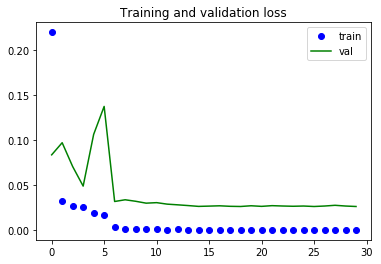

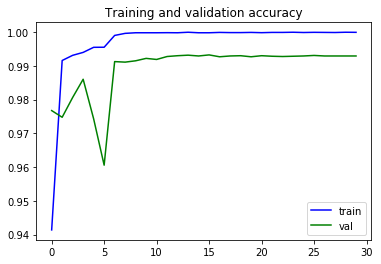

In [11]:
def  plot_loss_acc(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo')
    plt.plot(epochs, val_loss, 'g')
    plt.title('Training and validation loss')
    plt.legend(['train', 'val'], loc='upper right')
    filename= 'GTSRB_Approach08_loss.png'
    plt.savefig(filename)
    plt.show()
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'g')
    plt.title('Training and validation accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    filename= 'GTSRB_Approach08_accuracy.png'
    plt.savefig(filename)
    plt.show()
    
plot_loss_acc(history)